In [1]:
import os
import sys
os.environ["METIS_DLL"] = "/opt/homebrew/Cellar/metis/5.1.0/lib/libmetis.dylib"
os.environ["DATASET_DIR"] = os.path.abspath("../../datasets")
if os.path.abspath("../python") not in sys.path:
    sys.path.append(os.path.abspath("../python"))
import pandas as pd
import numpy as np
import string
import random
from scipy.io import loadmat
import matplotlib.pyplot as plt
import metis
import collections
from datasets import EdgeListDataset, DGraphFin
import dgl

/Users/rustamwarwick/miniconda3/envs/flink/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Models

## GraphSage

In [12]:
class SAGE(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , batchnorm=True):
        super(SAGE, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(dgl.nn.SAGEConv(in_channels, hidden_channels, aggregator_type="mean"))
        self.bns = torch.nn.ModuleList()

        if self.batchnorm:
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(dgl.nn.SAGEConv(hidden_channels, hidden_channels, aggregator_type="mean"))
            if self.batchnorm:
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.convs.append(dgl.nn.SAGEConv(hidden_channels, out_channels, aggregator_type="mean"))


    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        if self.batchnorm:
            for bn in self.bns:
                bn.reset_parameters()

    def forward(self, g, x):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(g[i],x)
            if self.batchnorm: 
                x = self.bns[i](x)
            x = torch.relu(x)
            x = torch.dropout(x, p=self.dropout, train=self.training)
        x = self.convs[-1](g[-1],x)
        return x.log_softmax(dim=-1)

## SIGNGNN

In [220]:
class SIGN(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , batchnorm=True):
        super(SIGN, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.num_layers = num_layers
        
        self.lins = torch.nn.ModuleList()
        self.lins.append(torch.nn.Linear(in_channels * self.num_layers, hidden_channels))
        self.bns = torch.nn.ModuleList()
        if self.batchnorm:
            self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        for _ in range(num_layers - 2):
            self.lins.append(torch.nn.Linear(hidden_channels, hidden_channels))
            if self.batchnorm:
                self.bns.append(torch.nn.BatchNorm1d(hidden_channels))
        self.lins.append(torch.nn.Linear(hidden_channels, out_channels))
       

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, g, x):
        raise Exception("This module is not working properly")
        g[0].srcdata['h'] = g[0].srcdata['x']
        total_emb = torch.zeros((g[-1].dstnodes().shape[0], self.in_channels * self.num_layers))
        for i, block in enumerate(g):
            if i > 0:
                block.srcdata['h'] = g[i - 1].dstdata['h']
            block.send_and_recv(block.edges(),dgl.function.copy_u('h', 'm'), dgl.function.sum('m', 'h')) # Aggregate just the messages
            # Add to total_emb
            for j,ID in enumerate(block.dstdata['_ID']):
                index_in_dst = (blocks[-1].dstdata['_ID']==ID).nonzero().tolist()
                if len(index_in_dst):
                    # Is contained in dest
                    total_emb[index_in_dst[0], i*self.in_channels:(i+1)*self.in_channels] = block.dstdata['h'][j]
        for i, lin in enumerate(self.lins[:-1]):
            total_emb = lin(total_emb)
            if self.batchnorm:
                total_emb = self.bns[i](total_emb)
            total_emb = torch.relu(total_emb)
            total_emb = torch.dropout(total_emb, p=self.dropout, train=self.training)
        total_emb = self.lins[-1](total_emb)
        return torch.log_softmax(total_emb, dim=-1)


## RLCGNN

In [337]:
class RLCGNNHomogenous(torch.nn.Module):
    def __init__(self
                 , in_channels
                 , hidden_channels
                 , out_channels
                 , num_layers
                 , dropout
                 , edge_types = 1
                 , batchnorm=True):
        super(RLCGNNHomogenous, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.edge_types = edge_types
        self.num_layers = num_layers
        self.similarity_mlps = torch.nn.ModuleList()
        self.threshold = 0.5
        self.convs = torch.nn.ModuleList()
        
        
        self.similarity_mlps.append(torch.nn.Linear(in_channels, out_channels))
        self.convs.append(dgl.nn.SAGEConv(in_channels, hidden_channels, aggregator_type="mean"))
        
        for _ in range(num_layers - 2):
            self.similarity_mlps.append(torch.nn.Linear(hidden_channels, out_channels))
            self.convs.append(dgl.nn.SAGEConv(hidden_channels, hidden_channels, aggregator_type="mean"))
            
        self.similarity_mlps.append(torch.nn.Linear(hidden_channels, out_channels))
        
        self.similarity_mlps.append(torch.nn.Linear(in_channels, out_channels)) # This one is for the dataset or dest vertex always
        self.convs.append(dgl.nn.SAGEConv(hidden_channels, out_channels, aggregator_type="mean"))
    
    def similarity_calc(self, similarity_mlp:int):
        def find(edge):
            dist = 1 - torch.norm(torch.sigmoid(similarity_mlp(edge.src['h'])) - torch.sigmoid(self.similarity_mlps[-1](edge.dst['x'])), dim=1, p=1)
            return {"sim":dist}
        return find
        
    
    def forward(self, g, x):
        for i, block in enumerate(g):
            with block.local_scope():
                block.srcdata['h'] = x # src nodes embeddings come from previous layer
                block.apply_edges(self.similarity_calc(self.similarity_mlps[i])) # dist is added to edata
                remaining_edges = block.filter_edges(lambda edge: edge.data['sim'] < self.threshold) # Take only similar edges based on a threadshold
                block.remove_edges(remaining_edges)
                x = self.convs[i](block, x)
        return torch.log_softmax(x, dim=-1)

In [338]:
class Dataset:
    def __init__(self, graph, train_mask, test_mask, val_mask, device=torch.device("cpu"), num_snapshots=12):
        self.graph = graph
        self.train_mask = train_mask
        self.test_mask = test_mask
        self.val_mask = val_mask
        self.num_snapshots = num_snapshots
        self.device = device
        
        
    def train(self, model, g=None, train_mask=None,  batch_size=512, shuffle=True, epochs=5):
        global blocks
        g = g if g is not None else self.graph
        train_mask = train_mask if train_mask is not None else self.train_mask
        model.train(True)
        sampler_full = dgl.dataloading.MultiLayerFullNeighborSampler(model.num_layers)
        dataloader = dgl.dataloading.DataLoader(
        g, train_mask, sampler_full,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=False,
        num_workers=4)
        opt = torch.optim.Adam(model.parameters(),lr=1e-4, weight_decay=1e-5)
        loss = torch.nn.NLLLoss(weight=torch.tensor([1, 1/self.class_imbalance]))
        for epoch in tqdm.tqdm(range(epochs)):
            losses = list()
            for input_nodes, output_nodes, blocks in dataloader:
                input_features = blocks[0].srcdata['x']
                output_labels = blocks[-1].dstdata['y']
                output_predictions = model(blocks, input_features)
                loss_value = loss(output_predictions, output_labels)
                opt.zero_grad()
                loss_value.backward()
                losses.append(loss_value.item())
                opt.step()
            print(np.array(losses).sum() / len(losses))
    
    def test(self, model, g = None, test_mask = None):
        g = g if g is not None else self.graph
        test_mask = test_mask if test_mask is not None else self.test_mask
        model.train(False)
        sampler_full = dgl.dataloading.MultiLayerFullNeighborSampler(model.num_layers)
        test_dataloader = dgl.dataloading.DataLoader(
            g, test_mask, sampler_full,
            batch_size=test_mask.shape[0],
            shuffle=True,
            drop_last=False,
            num_workers=4)
        input_nodes, output_nodes, blocks = next(iter(test_dataloader))
        input_features = blocks[0].srcdata['x']
        output_labels = blocks[-1].dstdata['y']
        return model(blocks, input_features), output_labels
    
    def get_snapshot(self, start:int, end = None):
        assert start < self.num_snapshots, "No more snapshots"
        snapshot_contains = math.ceil(self.graph.num_edges() / self.num_snapshots)
        if end is None:
            # Just retrieve the snapshot starting from previous one
            end = start + 1
        assert start < end, "Start snapshot should be less than end snapshot"
        start_ind = snapshot_contains * start
        end_ind = min(self.graph.num_edges(), snapshot_contains * end)
        g = dgl.graph((self.graph.edges()[0][start_ind:end_ind], self.graph.edges()[1][start_ind:end_ind]), num_nodes=self.graph.num_nodes())
        for key, val in self.graph.ndata.items():
            g.ndata[key] = val
        for key, val in self.graph.edata.items():
            g.edata[key] = val
        return g
        

# Code

In [340]:
def first_snapshot_train(model, dataset, epochs=100):
    rocs = list()
    for i in tqdm.tqdm(range(dataset.num_snapshots)):
        g = dataset.get_snapshot(0, i + 1)
        degrees = g.out_degrees() + g.in_degrees()
        if i==0:
                # Train only on first snapshot
                dataset.train(model, g=g, epochs=epochs, train_mask=dataset.train_mask[degrees[dataset.train_mask] > 1])
        output_predictions, output_labels = dataset.test(model, g, test_mask=dataset.test_mask[degrees[dataset.test_mask] > 1])
        output_predictions = output_predictions.exp()
        rocs.append(metrics.roc_auc_score(output_labels.detach(), output_predictions[:,1].detach()))
    return rocs

def online_learning(model, dataset, epochs=20):
    rocs = list()
    for i in tqdm.tqdm(range(dataset.num_snapshots)):
        g = dataset.get_snapshot(i)
        degrees = g.out_degrees() + g.in_degrees()
        dataset.train(model, g=g, epochs=epochs, train_mask=dataset.train_mask[degrees[dataset.train_mask] > 1])
        g = dataset.get_snapshot(0, i + 1)
        degrees = g.out_degrees() + g.in_degrees()
        output_predictions, output_labels = dataset.test(model, g, test_mask=dataset.test_mask[degrees[dataset.test_mask] > 1])
        output_predictions = output_predictions.exp()
        rocs.append(metrics.roc_auc_score(output_labels.detach(), output_predictions[:,1].detach()))
    return rocs

In [341]:
model = RLCGNNHomogenous(17, 128, 2, 3, 0.3)
dataset = DGraphFin(num_snapshots = 20)
first_snapshot_rocs = first_snapshot_train(model,dataset) 

  1%|██                                                                                                                                                                                                       | 1/100 [00:01<02:55,  1.77s/it]

0.8494529557228089



  2%|████                                                                                                                                                                                                     | 2/100 [00:03<02:27,  1.50s/it]

0.7067710113525391



  3%|██████                                                                                                                                                                                                   | 3/100 [00:04<02:19,  1.44s/it]

0.6447674322128296



  4%|████████                                                                                                                                                                                                 | 4/100 [00:05<02:13,  1.39s/it]

0.6198128080368042



  5%|██████████                                                                                                                                                                                               | 5/100 [00:07<02:13,  1.40s/it]

0.6149465608596801



  6%|████████████                                                                                                                                                                                             | 6/100 [00:08<02:08,  1.37s/it]

0.6047070479393005



  7%|██████████████                                                                                                                                                                                           | 7/100 [00:09<02:05,  1.35s/it]

0.5952415907382965



  8%|████████████████                                                                                                                                                                                         | 8/100 [00:11<02:02,  1.33s/it]

0.5878635239601135



  9%|██████████████████                                                                                                                                                                                       | 9/100 [00:12<02:01,  1.33s/it]

0.5694148564338684



 10%|████████████████████                                                                                                                                                                                    | 10/100 [00:13<01:59,  1.32s/it]

0.5682493662834167



 11%|██████████████████████                                                                                                                                                                                  | 11/100 [00:15<02:00,  1.35s/it]

0.5632122647762299



 12%|████████████████████████                                                                                                                                                                                | 12/100 [00:16<01:57,  1.33s/it]

0.5687128150463104



 13%|██████████████████████████                                                                                                                                                                              | 13/100 [00:17<01:55,  1.33s/it]

0.5580605506896973



 14%|████████████████████████████                                                                                                                                                                            | 14/100 [00:19<01:58,  1.38s/it]

0.551405155658722



 15%|██████████████████████████████                                                                                                                                                                          | 15/100 [00:20<01:58,  1.40s/it]

0.5517331969738006



 16%|████████████████████████████████                                                                                                                                                                        | 16/100 [00:22<01:56,  1.38s/it]

0.5592423492670059



 17%|██████████████████████████████████                                                                                                                                                                      | 17/100 [00:23<01:53,  1.36s/it]

0.5563340604305267



 18%|████████████████████████████████████                                                                                                                                                                    | 18/100 [00:24<01:49,  1.33s/it]

0.5456732439994813



 19%|██████████████████████████████████████                                                                                                                                                                  | 19/100 [00:25<01:46,  1.32s/it]

0.5496379566192627



 20%|████████████████████████████████████████                                                                                                                                                                | 20/100 [00:27<01:45,  1.32s/it]

0.5674892163276672



 21%|██████████████████████████████████████████                                                                                                                                                              | 21/100 [00:28<01:43,  1.31s/it]

0.5512530088424683



 22%|████████████████████████████████████████████                                                                                                                                                            | 22/100 [00:29<01:41,  1.31s/it]

0.5448813188076019



 23%|██████████████████████████████████████████████                                                                                                                                                          | 23/100 [00:31<01:40,  1.31s/it]

0.5502913427352906



 24%|████████████████████████████████████████████████                                                                                                                                                        | 24/100 [00:32<01:39,  1.31s/it]

0.5399891674518585



 25%|██████████████████████████████████████████████████                                                                                                                                                      | 25/100 [00:33<01:37,  1.30s/it]

0.5484287106990814



 26%|████████████████████████████████████████████████████                                                                                                                                                    | 26/100 [00:35<01:36,  1.30s/it]

0.5382777011394501



 27%|██████████████████████████████████████████████████████                                                                                                                                                  | 27/100 [00:36<01:34,  1.30s/it]

0.5287853801250457



 28%|████████████████████████████████████████████████████████                                                                                                                                                | 28/100 [00:37<01:33,  1.30s/it]

0.5400927436351776



 29%|█████████████████████████████████████████████████████████▉                                                                                                                                              | 29/100 [00:38<01:34,  1.33s/it]

0.5320354962348938



 30%|████████████████████████████████████████████████████████████                                                                                                                                            | 30/100 [00:40<01:34,  1.35s/it]

0.5470475399494171



 31%|██████████████████████████████████████████████████████████████                                                                                                                                          | 31/100 [00:41<01:32,  1.34s/it]

0.542535115480423



 32%|████████████████████████████████████████████████████████████████                                                                                                                                        | 32/100 [00:43<01:30,  1.33s/it]

0.5488153088092804



 33%|██████████████████████████████████████████████████████████████████                                                                                                                                      | 33/100 [00:44<01:28,  1.32s/it]

0.529289243221283



 34%|████████████████████████████████████████████████████████████████████                                                                                                                                    | 34/100 [00:45<01:26,  1.31s/it]

0.5495624339580536



 35%|██████████████████████████████████████████████████████████████████████                                                                                                                                  | 35/100 [00:46<01:25,  1.32s/it]

0.5488355946540833



 36%|████████████████████████████████████████████████████████████████████████                                                                                                                                | 36/100 [00:48<01:28,  1.38s/it]

0.537997395992279



 37%|██████████████████████████████████████████████████████████████████████████                                                                                                                              | 37/100 [00:49<01:27,  1.40s/it]

0.5421171915531159



 38%|████████████████████████████████████████████████████████████████████████████                                                                                                                            | 38/100 [00:51<01:25,  1.38s/it]

0.5481455636024475



 39%|██████████████████████████████████████████████████████████████████████████████                                                                                                                          | 39/100 [00:52<01:22,  1.35s/it]

0.5365220975875854



 40%|████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 40/100 [00:53<01:20,  1.34s/it]

0.5561264061927795



 41%|██████████████████████████████████████████████████████████████████████████████████                                                                                                                      | 41/100 [00:55<01:18,  1.33s/it]

0.5570181262493134



 42%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                    | 42/100 [00:56<01:16,  1.31s/it]

0.547308337688446



 43%|██████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 43/100 [00:57<01:14,  1.31s/it]

0.5066903281211853



 44%|████████████████████████████████████████████████████████████████████████████████████████                                                                                                                | 44/100 [00:59<01:15,  1.35s/it]

0.531413447856903



 45%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                                              | 45/100 [01:00<01:16,  1.38s/it]

0.5446880459785461



 46%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                            | 46/100 [01:01<01:13,  1.36s/it]

0.5332630431652069



 47%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 47/100 [01:03<01:11,  1.35s/it]

0.5367374622821808



 48%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                        | 48/100 [01:04<01:09,  1.35s/it]

0.527259783744812



 49%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                      | 49/100 [01:06<01:10,  1.39s/it]

0.5127493822574616



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                    | 50/100 [01:07<01:09,  1.38s/it]

0.5291580295562744



 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 51/100 [01:08<01:06,  1.36s/it]

0.5278783774375916



 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                | 52/100 [01:10<01:06,  1.39s/it]

0.5201103222370148



 53%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                              | 53/100 [01:11<01:05,  1.39s/it]

0.5384595561027526



 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 54/100 [01:12<01:02,  1.36s/it]

0.5355366313457489



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 55/100 [01:14<01:00,  1.34s/it]

0.5261020183563232



 56%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 56/100 [01:15<00:58,  1.34s/it]

0.5214483177661896



 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                      | 57/100 [01:16<00:57,  1.33s/it]

0.5137208640575409



 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 58/100 [01:18<00:55,  1.32s/it]

0.5284012973308563



 59%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 59/100 [01:19<00:53,  1.31s/it]

0.5196066188812256



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 60/100 [01:20<00:52,  1.31s/it]

0.5250883895158768



 61%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                              | 61/100 [01:22<00:50,  1.30s/it]

0.5269472467899322



 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 62/100 [01:23<00:49,  1.30s/it]

0.5143867754936218



 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 63/100 [01:24<00:49,  1.34s/it]

0.5149369394779205



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 64/100 [01:26<00:48,  1.35s/it]

0.5473422467708587



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 65/100 [01:27<00:46,  1.33s/it]

0.5320401096343994



 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 66/100 [01:28<00:44,  1.32s/it]

0.5313134980201721



 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 67/100 [01:29<00:43,  1.31s/it]

0.52437047123909



 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 68/100 [01:31<00:41,  1.31s/it]

0.5217385101318359



 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                              | 69/100 [01:32<00:40,  1.30s/it]

0.5177850615978241



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 70/100 [01:33<00:38,  1.30s/it]

0.5196470618247986



 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 71/100 [01:35<00:37,  1.30s/it]

0.5305737566947937



 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 72/100 [01:36<00:37,  1.32s/it]

0.5209843015670776



 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                      | 73/100 [01:37<00:35,  1.32s/it]

0.5152849411964416



 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 74/100 [01:39<00:34,  1.32s/it]

0.5043694758415223



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 75/100 [01:40<00:32,  1.31s/it]

0.5374658989906311



 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 76/100 [01:41<00:31,  1.30s/it]

0.5135503554344177



 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 77/100 [01:43<00:29,  1.30s/it]

0.531643123626709



 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 78/100 [01:44<00:28,  1.31s/it]

0.5060831546783447



 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 79/100 [01:45<00:27,  1.30s/it]

0.5010376560688019



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 80/100 [01:46<00:26,  1.30s/it]

0.5172208380699158



 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 81/100 [01:48<00:24,  1.30s/it]

0.5157392477989197



 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 82/100 [01:49<00:23,  1.31s/it]

0.5354009783267974



 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 83/100 [01:50<00:22,  1.31s/it]

0.541525536775589



 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 84/100 [01:52<00:20,  1.30s/it]

0.5192838358879089



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 85/100 [01:53<00:20,  1.38s/it]

0.5143481838703156



 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 86/100 [01:55<00:18,  1.35s/it]

0.5200757396221161



 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 87/100 [01:56<00:17,  1.35s/it]

0.5225714528560639



 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 88/100 [01:57<00:16,  1.34s/it]

0.5318272745609284



 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 89/100 [01:58<00:14,  1.33s/it]

0.5174908900260925



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 90/100 [02:00<00:13,  1.32s/it]

0.5209702825546265



 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 91/100 [02:01<00:11,  1.32s/it]

0.5262523603439331



 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 92/100 [02:02<00:10,  1.31s/it]

0.5094678032398224



 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 93/100 [02:04<00:09,  1.30s/it]

0.5068384242057801



 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 94/100 [02:05<00:07,  1.30s/it]

0.5164007699489593



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 95/100 [02:06<00:06,  1.32s/it]

0.5230528271198273



 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 96/100 [02:08<00:05,  1.31s/it]

0.524839653968811



 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 97/100 [02:09<00:03,  1.31s/it]

0.5217966508865356



 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 98/100 [02:10<00:02,  1.30s/it]

0.5393772864341736



 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 99/100 [02:12<00:01,  1.30s/it]

0.5636718118190766



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]

0.5316592252254486



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:45<00:00,  8.27s/it]


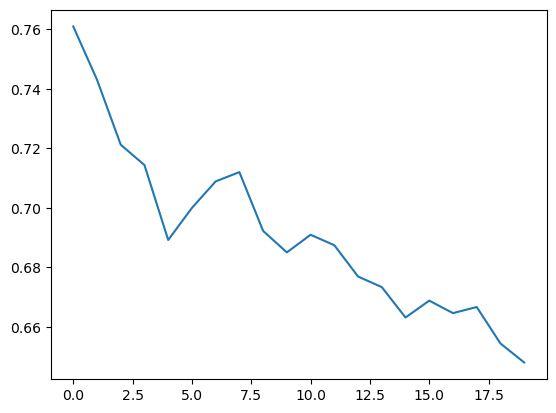

In [342]:
plt.plot(list(range(len(first_snapshot_rocs))), first_snapshot_rocs)

In [344]:
model = RLCGNNHomogenous(17, 128, 2, 3, 0.3)
dataset = DGraphFin(num_snapshots = 20)
first_snapshot_rocs = online_learning(model,dataset)

  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:33,  1.78s/it]

1.0098615193367004



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:03<00:28,  1.58s/it]

0.7367893552780151



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:04<00:24,  1.46s/it]

0.667280365228653



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:05<00:22,  1.40s/it]

0.6484844458103179



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:07<00:21,  1.43s/it]

0.6192578697204589



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:08<00:19,  1.42s/it]

0.5993938171863555



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:10<00:18,  1.44s/it]

0.5617224860191345



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:11<00:16,  1.41s/it]

0.5684212982654572



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:12<00:15,  1.40s/it]

0.5596633338928223



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:14<00:13,  1.37s/it]

0.5492336130142212



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:15<00:12,  1.36s/it]

0.5604619324207306



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:16<00:10,  1.33s/it]

0.5781438148021698



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:18<00:09,  1.33s/it]

0.5432426273822785



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:19<00:08,  1.34s/it]

0.5121521371603012



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:20<00:06,  1.33s/it]

0.5353029930591583



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:22<00:05,  1.34s/it]

0.5223321425914764



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:23<00:04,  1.37s/it]

0.5322096407413482



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:25<00:02,  1.38s/it]

0.5275398457050323



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:26<00:01,  1.42s/it]

0.5167385613918305



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.39s/it]

0.5053941309452057



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:23,  1.22s/it]

0.5771431492434608



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:21,  1.20s/it]

0.5464512821700838



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:03<00:20,  1.22s/it]

0.5344769143395953



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:04<00:19,  1.24s/it]

0.49956809480985004



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:06<00:18,  1.24s/it]

0.480125046438641



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:07<00:17,  1.24s/it]

0.5249446398682065



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:08<00:16,  1.26s/it]

0.49574172165658736



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:09<00:15,  1.27s/it]

0.47139136327637565



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:11<00:13,  1.25s/it]

0.45706207553545636



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:12<00:12,  1.23s/it]

0.4749169382784102



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:13<00:10,  1.21s/it]

0.4680952512555652



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:14<00:09,  1.21s/it]

0.47661350667476654



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:15<00:08,  1.21s/it]

0.46703388459152645



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:17<00:07,  1.23s/it]

0.47066552771462333



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:18<00:06,  1.21s/it]

0.4222414443890254



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:19<00:04,  1.20s/it]

0.46423092318905723



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:20<00:03,  1.20s/it]

0.48080689708391827



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:22<00:02,  1.21s/it]

0.434276948372523



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:23<00:01,  1.20s/it]

0.4544016718864441



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]

0.4535414096381929



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:24,  1.32s/it]

0.4769153945586261



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:23,  1.30s/it]

0.4528643401230083



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:03<00:21,  1.29s/it]

0.4294810663251316



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:05<00:20,  1.29s/it]

0.4215269877630122



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:06<00:19,  1.31s/it]

0.41839737927212434



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:07<00:18,  1.29s/it]

0.40922507994315205



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:08<00:16,  1.27s/it]

0.41066580484895143



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:10<00:15,  1.25s/it]

0.4081074612982133



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:11<00:13,  1.24s/it]

0.3912392030743992



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:12<00:12,  1.21s/it]

0.4058445937493268



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:13<00:10,  1.21s/it]

0.4098926940385033



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:15<00:09,  1.22s/it]

0.40077606544775124



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:16<00:08,  1.21s/it]

0.39901364726178784



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:17<00:07,  1.20s/it]

0.39808017015457153



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:18<00:05,  1.20s/it]

0.39676955166985006



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:19<00:04,  1.20s/it]

0.3990374821073869



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:21<00:03,  1.21s/it]

0.3882489502429962



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:22<00:02,  1.21s/it]

0.3962519423050039



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:23<00:01,  1.23s/it]

0.3851686120033264



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.24s/it]

0.3773302821552052



  5%|██████████                                                                                                                                                                                                | 1/20 [00:02<00:46,  2.44s/it]

0.5710596179260927



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:03<00:30,  1.69s/it]

0.5434948872117435



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:04<00:24,  1.45s/it]

0.483769532512216



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:05<00:21,  1.33s/it]

0.47716811299324036



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:07<00:19,  1.27s/it]

0.4643464526709388



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:08<00:17,  1.23s/it]

0.4640926806365742



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:09<00:15,  1.20s/it]

0.4554098178358639



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:10<00:14,  1.19s/it]

0.4490116974886726



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:11<00:13,  1.18s/it]

0.43924015760421753



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:12<00:11,  1.17s/it]

0.4371969594674952



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:14<00:10,  1.17s/it]

0.4371328090920168



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:15<00:09,  1.16s/it]

0.4397347937611973



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:16<00:08,  1.17s/it]

0.41805708408355713



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:17<00:06,  1.16s/it]

0.42698876822696014



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:18<00:05,  1.15s/it]

0.44433847770971413



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:19<00:04,  1.16s/it]

0.4398454199819004



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:21<00:03,  1.19s/it]

0.42638935061062083



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:22<00:02,  1.21s/it]

0.4552811331608716



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:23<00:01,  1.20s/it]

0.4271341702517341



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.23s/it]

0.42522412363220663



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:23,  1.25s/it]

0.6734305523774203



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:22,  1.23s/it]

0.5613032439175774



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:03<00:21,  1.24s/it]

0.5141335094676298



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:04<00:19,  1.24s/it]

0.4909653593512142



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:06<00:18,  1.22s/it]

0.48560070816208334



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:07<00:16,  1.20s/it]

0.5060202672201044



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:08<00:15,  1.18s/it]

0.45619609250741844



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:09<00:14,  1.17s/it]

0.46512576762367697



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:10<00:12,  1.16s/it]

0.4451111905715045



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:11<00:11,  1.16s/it]

0.4573069758274976



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:13<00:10,  1.15s/it]

0.4355664744096644



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:14<00:09,  1.16s/it]

0.45145146548748016



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:15<00:08,  1.16s/it]

0.4619032267261954



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:16<00:06,  1.16s/it]

0.4378814583315569



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:17<00:05,  1.16s/it]

0.4356515968547148



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:18<00:04,  1.16s/it]

0.4375373028657016



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:20<00:03,  1.16s/it]

0.45016207852784323



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:21<00:02,  1.16s/it]

0.41242534097503214



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:22<00:01,  1.15s/it]

0.43648366016500134



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.17s/it]

0.42595402896404266



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:23,  1.24s/it]

0.5486639755613664



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:21,  1.19s/it]

0.4917856673983967



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:03<00:19,  1.16s/it]

0.49357274875921364



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:04<00:18,  1.15s/it]

0.4970015462707071



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:05<00:17,  1.15s/it]

0.4808500496780171



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:06<00:16,  1.15s/it]

0.46268492761780233



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:08<00:14,  1.15s/it]

0.45865189152605396



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:09<00:13,  1.15s/it]

0.4595766085035661



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:10<00:12,  1.15s/it]

0.4529528547735775



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:11<00:11,  1.16s/it]

0.4427324603585636



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:12<00:10,  1.16s/it]

0.43432504376944375



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:13<00:09,  1.16s/it]

0.4622529070166981



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:15<00:08,  1.16s/it]

0.4578906087314381



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:16<00:06,  1.15s/it]

0.4389599614283618



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:17<00:05,  1.15s/it]

0.425789929488126



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:18<00:04,  1.16s/it]

0.4314430031706305



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:19<00:03,  1.16s/it]

0.44220055727397695



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:20<00:02,  1.16s/it]

0.44360200710156383



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:21<00:01,  1.15s/it]

0.4416506343028125



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.16s/it]

0.41950681805610657



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:24,  1.28s/it]

0.772639719878926



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:22,  1.23s/it]

0.623060908387689



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:03<00:20,  1.19s/it]

0.5913135391824386



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:04<00:18,  1.18s/it]

0.5691103777464699



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:05<00:17,  1.16s/it]

0.5351812909631168



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:07<00:16,  1.17s/it]

0.5219356330002055



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:08<00:15,  1.16s/it]

0.5148323230883655



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:09<00:13,  1.16s/it]

0.5205313370508307



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:10<00:12,  1.16s/it]

0.49955692361382875



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:11<00:11,  1.16s/it]

0.48986611646764416



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:12<00:10,  1.19s/it]

0.4798886793501237



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:14<00:09,  1.19s/it]

0.47492289367844076



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:15<00:08,  1.18s/it]

0.4722317571149153



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:16<00:07,  1.18s/it]

0.47085119696224437



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:17<00:05,  1.17s/it]

0.46928274105576906



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:18<00:04,  1.16s/it]

0.45321954699123607



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:19<00:03,  1.17s/it]

0.4625667228418238



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:21<00:02,  1.19s/it]

0.4587094240328845



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:22<00:01,  1.18s/it]

0.44289584808489857



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]

0.45639049743904786



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:23,  1.23s/it]

0.6173121087691363



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:21,  1.19s/it]

0.5691756798940546



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:03<00:19,  1.17s/it]

0.5216651330975925



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:04<00:18,  1.16s/it]

0.5099790131344515



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:05<00:17,  1.15s/it]

0.5070264462162467



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:06<00:16,  1.15s/it]

0.4703039579531726



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:08<00:14,  1.15s/it]

0.47701065680559945



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:09<00:13,  1.15s/it]

0.4912198466413161



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:10<00:12,  1.17s/it]

0.490443254218382



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:11<00:11,  1.19s/it]

0.4852900207042694



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:12<00:10,  1.19s/it]

0.46538686577011557



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:14<00:09,  1.18s/it]

0.4799358985003303



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:15<00:08,  1.17s/it]

0.48238591762150035



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:16<00:07,  1.19s/it]

0.46133789946051207



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:17<00:06,  1.24s/it]

0.478152978069642



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:19<00:04,  1.23s/it]

0.45427587102441225



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:20<00:03,  1.20s/it]

0.47852930426597595



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:21<00:02,  1.18s/it]

0.45461537031566396



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:22<00:01,  1.17s/it]

0.4579990716541515



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]

0.45002173150286956



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:25,  1.34s/it]

0.6421234789821837



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:24,  1.34s/it]

0.542581873635451



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:04<00:23,  1.36s/it]

0.49254753357834286



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:05<00:21,  1.34s/it]

0.4803492600719134



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:06<00:19,  1.32s/it]

0.48844022552172345



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:07<00:18,  1.32s/it]

0.45324847598870593



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:09<00:16,  1.31s/it]

0.46796511279212105



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:10<00:15,  1.30s/it]

0.43676123519738513



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:11<00:14,  1.33s/it]

0.4788230342997445



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:13<00:13,  1.35s/it]

0.43653788831498885



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:14<00:11,  1.33s/it]

0.44742882086171043



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:15<00:10,  1.33s/it]

0.4234749236040645



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:17<00:09,  1.30s/it]

0.4322112633122338



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:18<00:07,  1.29s/it]

0.45109958615567947



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:19<00:06,  1.32s/it]

0.4222467574808333



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:21<00:05,  1.32s/it]

0.42289263175593483



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:22<00:03,  1.31s/it]

0.4142330553796556



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:23<00:02,  1.31s/it]

0.42500325043996173



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:25<00:01,  1.31s/it]

0.4521395083930757



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.32s/it]

0.42785900831222534



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:24,  1.30s/it]

0.5852853506803513



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:22,  1.27s/it]

0.5198097737396464



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:03<00:21,  1.26s/it]

0.4784737790332121



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:05<00:21,  1.32s/it]

0.4595331672359915



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:06<00:19,  1.29s/it]

0.45643043868681965



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:07<00:17,  1.28s/it]

0.4440363014445585



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:09<00:20,  1.61s/it]

0.43250659809393044



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:11<00:18,  1.52s/it]

0.43373435560394735



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:12<00:15,  1.45s/it]

0.4289279054192936



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:14<00:16,  1.65s/it]

0.42273780703544617



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:16<00:14,  1.61s/it]

0.4125062735641704



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:17<00:12,  1.58s/it]

0.3929212610511219



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:18<00:10,  1.47s/it]

0.40548483676770153



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:20<00:08,  1.39s/it]

0.39781879852799806



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:21<00:06,  1.33s/it]

0.4261907409219181



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:22<00:05,  1.28s/it]

0.3973512789782356



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:23<00:03,  1.25s/it]

0.4084715527646682



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:24<00:02,  1.22s/it]

0.402132511138916



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:26<00:01,  1.22s/it]

0.39146101387108073



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.36s/it]

0.39940080484923196



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:24,  1.28s/it]

0.565378140000736



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:22,  1.24s/it]

0.5037527259658364



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:03<00:20,  1.22s/it]

0.46756109595298767



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:04<00:19,  1.19s/it]

0.4655032771475175



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:06<00:17,  1.18s/it]

0.44847841473186717



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:07<00:16,  1.18s/it]

0.4483434452730067



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:08<00:15,  1.17s/it]

0.4581081288702348



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:09<00:14,  1.23s/it]

0.467223651268903



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:10<00:13,  1.23s/it]

0.4627666368204005



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:12<00:12,  1.21s/it]

0.4433480588828816



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:13<00:10,  1.20s/it]

0.44370593919473533



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:14<00:09,  1.19s/it]

0.4439327050657833



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:15<00:08,  1.19s/it]

0.44255331158638



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:16<00:07,  1.18s/it]

0.4502501978593714



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:17<00:05,  1.17s/it]

0.43412310235640583



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:19<00:04,  1.17s/it]

0.4425771490615957



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:20<00:03,  1.18s/it]

0.43419454816509695



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:21<00:02,  1.18s/it]

0.43958994044977073



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:22<00:01,  1.20s/it]

0.4535993162323447



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]

0.4441278278827667



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:25,  1.32s/it]

0.5681863085312002



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:25,  1.42s/it]

0.5431650894529679



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:04<00:23,  1.40s/it]

0.5259529650211334



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:05<00:21,  1.34s/it]

0.5323338403421289



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:06<00:19,  1.32s/it]

0.5232337134725907



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:07<00:17,  1.27s/it]

0.49964385874131145



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:09<00:16,  1.24s/it]

0.5139470152995166



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:10<00:14,  1.22s/it]

0.5159444405752069



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:11<00:13,  1.24s/it]

0.49272074944832744



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:12<00:12,  1.22s/it]

0.5239538024453556



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:13<00:10,  1.20s/it]

0.5050693802973804



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:15<00:09,  1.19s/it]

0.5242488261531381



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:16<00:08,  1.19s/it]

0.5139355238746194



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:17<00:07,  1.19s/it]

0.5059631168842316



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:18<00:05,  1.19s/it]

0.48600386696703296



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:19<00:04,  1.19s/it]

0.5103139403988334



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:21<00:03,  1.20s/it]

0.48636986227596507



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:22<00:02,  1.19s/it]

0.4978487877284779



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:23<00:01,  1.18s/it]

0.4971801848972545



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:24<00:00,  1.22s/it]

0.48799118399620056



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:26,  1.38s/it]

0.5107454412123736



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:22,  1.26s/it]

0.48571935471366434



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:04<00:23,  1.36s/it]

0.49663834361469045



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:05<00:20,  1.29s/it]

0.4656190363799824



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:06<00:18,  1.25s/it]

0.44493942050372853



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:08<00:21,  1.57s/it]

0.4495737763012157



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:09<00:19,  1.48s/it]

0.4456876095603494



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:11<00:16,  1.38s/it]

0.4542642744148479



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:12<00:14,  1.33s/it]

0.44930420377675223



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:13<00:12,  1.30s/it]

0.43052755208576426



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:14<00:11,  1.26s/it]

0.4292611234328326



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:15<00:09,  1.23s/it]

0.43263941652634563



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:16<00:08,  1.21s/it]

0.43373814751120177



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:18<00:07,  1.19s/it]

0.4184429785784553



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:19<00:05,  1.18s/it]

0.425316803595599



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:20<00:04,  1.17s/it]

0.4350466587964226



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:21<00:03,  1.17s/it]

0.42579535175772276



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:22<00:02,  1.20s/it]

0.4241253979065839



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:24<00:01,  1.19s/it]

0.421162147732342



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]

0.4314886822420008



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:24,  1.28s/it]

0.5990749176810769



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:23,  1.29s/it]

0.5369352242525887



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:04<00:24,  1.44s/it]

0.524797614882974



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:06<00:25,  1.62s/it]

0.5099384539267596



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:07<00:22,  1.49s/it]

0.4819201599149143



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:08<00:21,  1.52s/it]

0.50142961565186



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:10<00:18,  1.46s/it]

0.49515863376505237



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:12<00:19,  1.64s/it]

0.49825258991297555



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:13<00:17,  1.61s/it]

0.4754260638180901



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:15<00:14,  1.50s/it]

0.4858132022268632



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:16<00:12,  1.40s/it]

0.48059817096766305



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:17<00:11,  1.42s/it]

0.47907372432596546



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:18<00:09,  1.36s/it]

0.486224972149905



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:20<00:07,  1.30s/it]

0.4796813533586614



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:21<00:06,  1.26s/it]

0.4739045185201308



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:22<00:04,  1.23s/it]

0.4720064629526699



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:23<00:03,  1.21s/it]

0.48048121087691364



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:24<00:02,  1.20s/it]

0.4834977002704845



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:25<00:01,  1.19s/it]

0.45776286019998436



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.35s/it]

0.4692174213774064



  0%|                                                                                                                                                                                                                  | 0/20 [00:00<?, ?it/s]/Users/rustamwarwick/miniconda3/envs/flink/lib/python3.8/site-packages/dgl-0.9.0-py3.8-macosx-11.0-arm64.egg/dgl/core.py:79: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning('The input graph for the user-defined edge function ' \

  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:24,  1.31s/it]

0.6623297449615266



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:21,  1.22s/it]

0.5526486167477237



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:03<00:20,  1.21s/it]

0.5351790086262755



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:04<00:19,  1.21s/it]

0.5251742990480529



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:06<00:17,  1.19s/it]

0.5340985755125681



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:07<00:16,  1.19s/it]

0.5417727256814638



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:08<00:15,  1.19s/it]

0.48702381561452057



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:09<00:14,  1.18s/it]

0.4797218574417962



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:10<00:13,  1.21s/it]

0.47553979108730954



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:12<00:11,  1.20s/it]

0.45110267649094266



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:13<00:10,  1.19s/it]

0.48467519051498836



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:14<00:09,  1.19s/it]

0.4878419182366795



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:15<00:08,  1.18s/it]

0.5096714049577713



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:16<00:07,  1.18s/it]

0.47421983370764387



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:17<00:05,  1.17s/it]

0.4452587539951007



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:19<00:04,  1.17s/it]

0.43844344151309794



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:20<00:03,  1.17s/it]

0.4406338118844562



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:21<00:02,  1.17s/it]

0.4850989282131195



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:22<00:01,  1.17s/it]

0.44922862553762066



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.19s/it]

0.4325722915172163



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:24,  1.28s/it]

0.599888414144516



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:22,  1.22s/it]

0.5403708412366754



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:03<00:20,  1.19s/it]

0.5225069733227



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:04<00:18,  1.17s/it]

0.5072755743475521



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:05<00:17,  1.18s/it]

0.5043411009451922



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:07<00:16,  1.18s/it]

0.4812913624679341



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:08<00:15,  1.18s/it]

0.4687645549283308



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:09<00:14,  1.18s/it]

0.47266433870091157



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:10<00:13,  1.18s/it]

0.4653586657608257



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:11<00:11,  1.18s/it]

0.4544385022976819



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:13<00:10,  1.18s/it]

0.44898056808639975



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:14<00:09,  1.17s/it]

0.4488522533108206



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:15<00:08,  1.18s/it]

0.4532374038415797



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:16<00:07,  1.18s/it]

0.44846946176360636



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:17<00:05,  1.17s/it]

0.45753567709642295



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:18<00:04,  1.19s/it]

0.4500081802115721



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:20<00:03,  1.18s/it]

0.4383155107498169



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:21<00:02,  1.19s/it]

0.44517233967781067



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:22<00:01,  1.20s/it]

0.45118968364070444



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:23<00:00,  1.18s/it]

0.4310113699997173



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:24,  1.28s/it]

0.6744425857768339



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:21,  1.22s/it]

0.5964402977158042



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:03<00:20,  1.20s/it]

0.561026031480116



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:04<00:19,  1.19s/it]

0.5257334840648314



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:05<00:17,  1.19s/it]

0.5258271571467904



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:07<00:16,  1.18s/it]

0.544423841378268



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:08<00:15,  1.17s/it]

0.5123292014879339



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:09<00:13,  1.16s/it]

0.5047265273683211



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:10<00:13,  1.20s/it]

0.5039799967232872



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:12<00:12,  1.25s/it]

0.5007177012808183



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:13<00:11,  1.27s/it]

0.5062164909699384



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:14<00:10,  1.26s/it]

0.4912671008530785



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:16<00:09,  1.33s/it]

0.488933487850077



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:17<00:08,  1.46s/it]

0.496906298048356



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:19<00:06,  1.38s/it]

0.48510070583399606



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:20<00:05,  1.32s/it]

0.47319449747309966



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:21<00:03,  1.29s/it]

0.47086400494855996



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:22<00:02,  1.26s/it]

0.4776698754114263



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:23<00:01,  1.26s/it]

0.4758465255008024



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.26s/it]

0.47479282670161305



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:27,  1.46s/it]

0.607356691902334



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:24,  1.39s/it]

0.5450166111642664



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:04<00:22,  1.35s/it]

0.5405309240926396



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:05<00:21,  1.32s/it]

0.5453025346452539



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:06<00:19,  1.32s/it]

0.5444085733457045



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:07<00:18,  1.32s/it]

0.5452554700049487



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:09<00:17,  1.31s/it]

0.5313145179640163



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:10<00:15,  1.29s/it]

0.5389577299356461



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:11<00:14,  1.28s/it]

0.5284792984073813



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:13<00:12,  1.26s/it]

0.5156146897511049



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:14<00:11,  1.26s/it]

0.5196147804910486



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:15<00:10,  1.27s/it]

0.5145676908167925



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:16<00:08,  1.26s/it]

0.5221221189607274



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:18<00:08,  1.41s/it]

0.5268127335743471



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:20<00:07,  1.47s/it]

0.529738422144543



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:21<00:05,  1.41s/it]

0.5422261980446902



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:22<00:04,  1.36s/it]

0.5304360376162962



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:23<00:02,  1.33s/it]

0.5051123689521443



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:25<00:01,  1.31s/it]

0.514529593966224



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/it]

0.5264510160142725



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:26,  1.38s/it]

0.5521890267177865



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:25,  1.41s/it]

0.529712732191439



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:04<00:23,  1.39s/it]

0.5091696083545685



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:05<00:22,  1.41s/it]

0.5058090631608609



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:06<00:20,  1.40s/it]

0.4980478816562229



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:08<00:19,  1.38s/it]

0.48973064510910597



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:10<00:22,  1.75s/it]

0.4855210637604749



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:12<00:20,  1.70s/it]

0.4894693438653593



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:13<00:17,  1.60s/it]

0.4870570147479022



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:15<00:15,  1.54s/it]

0.48307637263227393



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:16<00:13,  1.48s/it]

0.4848378709069005



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:17<00:11,  1.44s/it]

0.4995865027109782



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:19<00:09,  1.42s/it]

0.4712601392357438



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:20<00:08,  1.40s/it]

0.4815741070994624



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:21<00:06,  1.38s/it]

0.4794311931839696



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:23<00:05,  1.38s/it]

0.47541819126517687



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:24<00:04,  1.38s/it]

0.477316677570343



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:26<00:02,  1.39s/it]

0.46813377406862045



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:27<00:01,  1.46s/it]

0.469906704293357



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:29<00:00,  1.46s/it]

0.4768466000203733



  5%|██████████                                                                                                                                                                                                | 1/20 [00:01<00:26,  1.41s/it]

0.6592869364789554



 10%|████████████████████▏                                                                                                                                                                                     | 2/20 [00:02<00:24,  1.36s/it]

0.6179037445357868



 15%|██████████████████████████████▎                                                                                                                                                                           | 3/20 [00:04<00:23,  1.38s/it]

0.625394310270037



 20%|████████████████████████████████████████▍                                                                                                                                                                 | 4/20 [00:05<00:22,  1.38s/it]

0.5879169159701892



 25%|██████████████████████████████████████████████████▌                                                                                                                                                       | 5/20 [00:06<00:20,  1.38s/it]

0.6187667921185493



 30%|████████████████████████████████████████████████████████████▌                                                                                                                                             | 6/20 [00:08<00:19,  1.37s/it]

0.5804349588496345



 35%|██████████████████████████████████████████████████████████████████████▋                                                                                                                                   | 7/20 [00:09<00:17,  1.38s/it]

0.5811697138207299



 40%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                                         | 8/20 [00:10<00:16,  1.37s/it]

0.5690074839762279



 45%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                               | 9/20 [00:12<00:15,  1.37s/it]

0.571160056761333



 50%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                    | 10/20 [00:13<00:13,  1.37s/it]

0.5597795503480094



 55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 11/20 [00:15<00:12,  1.37s/it]

0.5544627213052341



 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 12/20 [00:16<00:10,  1.37s/it]

0.5492714302880424



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 13/20 [00:17<00:09,  1.38s/it]

0.551751183612006



 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                            | 14/20 [00:19<00:08,  1.38s/it]

0.5577725235904966



 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 15/20 [00:20<00:06,  1.38s/it]

0.5699533522129059



 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 16/20 [00:22<00:05,  1.38s/it]

0.5532735671315875



 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 17/20 [00:23<00:04,  1.38s/it]

0.550467634839671



 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 18/20 [00:24<00:02,  1.37s/it]

0.541242533496448



 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 19/20 [00:26<00:01,  1.37s/it]

0.5536900513938495



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:27<00:00,  1.37s/it]

0.5549755394458771



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [09:00<00:00, 27.03s/it]


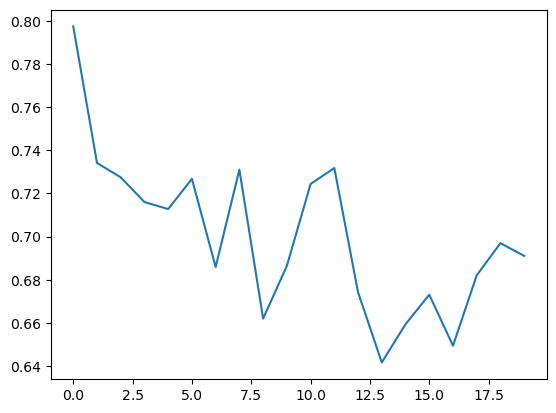

In [345]:
plt.plot(list(range(len(first_snapshot_rocs))), first_snapshot_rocs)